This is a live notebook with experimental code to develop analysis investigating the correlation between features.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import itertools
import json

import scipy.stats as spstats
# fourier transform
from scipy.fft import fft, ifft

from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
# from statsmodels.tsa.api import acf, graphics, pacf
from statsmodels.tsa.ar_model import AutoReg
# from statsmodels.tsa.ar_model import ar_select_order

import os
print(os.listdir("."))


import re
res_digit = r'[0-9]'


['debug_windowing_data.ipynb', 'testing_mlpwrapper.ipynb', 'logs', 'gait_data_features.ipynb', 'feature_development.ipynb', 'data', 'feature_analysis.ipynb', 'merging_dataframes.ipynb', 'data_and_processing_description.ipynb', 'featured_prediction_random_forest.ipynb', 'window_timings_and_IBI.ipynb', 'gait_data_exploration.ipynb', 'Analyse_results.ipynb', '.ipynb_checkpoints', 'loading_e4_data.ipynb', 'data_investigation_scratch.ipynb', 'grouping_and_crossvalidation.ipynb', 'sample-entropy-numba-impl.ipynb', 'featured_prediction.ipynb']


In [2]:
# This is a hack to make the library in the parent folder available for imoprts
# A better solution is by np8 here:
# https://stackoverflow.com/questions/714063/importing-modules-from-parent-folder
import sys
import os
import inspect

thisdir = sys.path[0]
print(f"thisdir = {thisdir}")
parentdir = os.path.dirname(thisdir)
#print(f"parentdir = {parentdir}")
if not parentdir in sys.path:
    print("Adding parent directory to python path")
    sys.path.insert(1, parentdir)
else:
    print("Skipping adding parent direct to path (there already)")

print(f"sys.path =\n{sys.path}")



thisdir = /home/luke/git/external/predicament/notebooks
Adding parent directory to python path
sys.path =
['/home/luke/git/external/predicament/notebooks', '/home/luke/git/external/predicament', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/luke/.local/lib/python3.10/site-packages', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/lib/python3.10/dist-packages']


In [3]:
## ensure relative path to data directory is sound
# for the notebook we need to modify the BASE_DATA_FOLDER
import os 
os.environ['PREDICAMENT_DATA_DIR'] =  '../data'

In [4]:
from predicament.utils.config import DREEM_EEG_CHANNELS
from predicament.utils.config import FEATURED_BASE_PATH
from predicament.utils.config import WINDOWED_BASE_PATH
from predicament.utils.file_utils import drop_nan_cols


from predicament.data.timeseries import create_participant_data_edf_only
from predicament.data.windowed import window_all_participants_data
from predicament.data.windowed import merge_condition_data
from predicament.data.partitioning import between_subject_cv_partition

from predicament.data.features import MAXIMAL_FEATURE_GROUP
from predicament.data.features import STATS_FEATURE_GROUP
from predicament.data.features import INFO_FEATURE_GROUP
from predicament.data.features import FREQ_FEATURE_GROUP
from predicament.data.features import convert_timeseries_to_features
from predicament.data.features import filter_features
from prepare_evaluation_data import load_dataframe_and_config
from prepare_evaluation_data import write_dataframe_and_config


In [5]:
from predicament.utils.config import E4_CSV_FILES
from predicament.utils.config import E4_FULL_DIRPATHS
E4_FULL_DIRPATHS

{'VG_01': '../data/CARE_HOME_DATA/./VG01/E4_8921_15_44/',
 'VG_03': '../data/CARE_HOME_DATA/./VG03/E4_9921_12_16/',
 'VG_05': '../data/CARE_HOME_DATA/./VG05/E4_9921_13_24/',
 'VG_06': '../data/CARE_HOME_DATA/./VG06/E4_51021_13_33/',
 'VG_07': '../data/CARE_HOME_DATA/./VG07/E4_51021_15_39/',
 'VG_08': '../data/CARE_HOME_DATA/./VG08/E4_71021_10_42/',
 'VG_09': '../data/CARE_HOME_DATA/./VG09/E4_11221_14_46/',
 'VG_10': '../data/CARE_HOME_DATA/./VG10/E4_31221_11_17/',
 'VH_01': '../data/CARE_HOME_DATA/./VH01/E4_61021_11_03/',
 'VH_02': '../data/CARE_HOME_DATA/./VH02/E4_61021_13_59/',
 'VH_03': '../data/CARE_HOME_DATA/./VH03/E4_11221_11_22/'}

In [6]:
import matplotlib.pyplot as plt

def scatter_plot_features(featured_df, feature_names, with_jitter=False, jitter=1e-5):
    feature_data = featured_df[feature_names].to_numpy()

    if with_jitter:
        col_means = np.mean(feature_data, axis=0)
        noise = (np.random.random(feature_data.shape)*2-1)*jitter*col_means.reshape((1,-1))
        feature_data = feature_data + noise
    N,F = feature_data.shape
    fig, axgrid = plt.subplots(F,F, figsize=(10,8))
    for i in range(F):
        for j in range(F):
            if i != j:
                axgrid[i,j].scatter(feature_data[:,j],feature_data[:,i], marker='.', s=0.5)
            else:
                try:
                    axgrid[i,i].hist(feature_data[:,i])
                except:
                    print(f"Failed to histogram {i}th feature {feature_names[i]}")
                    inf_val_positions = ~np.isfinite(feature_data[:,i])
                    print(f"inf_val_positions = {inf_val_positions}")
                    axgrid[i,i].hist(feature_data[~inf_val_positions,i])
            axgrid[i,j].set_xticks([])
            axgrid[i,j].set_yticks([])

            if j == 0:
                axgrid[i,j].set_ylabel(feature_names[i], rotation='horizontal', ha='right')
            if i == F-1:
                axgrid[i,j].set_xlabel(feature_names[j], rotation='vertical')
    plt.tight_layout()

## dreem (EEG) data or E4 data



In [7]:
subdir = 'dreem_4secs'
featured_data_dir = os.path.join(FEATURED_BASE_PATH,subdir)

featured_df, featured_config = load_dataframe_and_config(
    featured_data_dir, 'featured.csv')

Reading dataframe from ../data/featured/dreem_4secs/featured.csv
Reading config from ../data/featured/dreem_4secs/details.cfg


In [8]:
n_channels = featured_config['LOAD']['n_channels']
channels = featured_config['LOAD']['channels']
participant_list = featured_config['LOAD']['participant_list']
Fs = featured_config['LOAD']['sample_rate']
window_size = featured_config['LOAD']['window_size']
time = window_size/Fs
print(f"Fs: {Fs}, n_samples = {window_size}, time: {time}s, n_channels: {n_channels}")

Fs: 250, n_samples = 1024, time: 4.096s, n_channels: 4


In [9]:
channels

['EEG Fpz-O1', 'EEG Fpz-O2', 'EEG Fpz-F7', 'EEG Fpz-F8']

In [10]:
# Filter columns with infinite values and record removed columns
removed_columns = []
for col in featured_df.select_dtypes(include=[np.number]).columns:
    if np.any(np.isinf(featured_df[col])):
        removed_columns.append(col)
        del featured_df[col]
        
removed_columns

[]

In [11]:
# features
feature_names = featured_config['FEATURED']['feature_names']
print("Before removal")
print(f"feature_names= {feature_names} (len = {len(feature_names)})")
print("After removal")
feature_names = [ f for f in feature_names if not f in removed_columns]
print(f"feature_names= {feature_names} (len = {len(feature_names)}")


Before removal
feature_names= ['LempelZivComplexity[b=1]', 'SD2', 'arCoeff10', 'Correlation0', 'FreqSkewness1', 'arCoeff12', 'IQR1', 'arCoeff4', 'FreqKurtosis0', 'MeanFreq3', 'Min3', 'MAD0', 'arCoeff7', 'LempelZivEntropy[b=1][3]', 'MeanFreq0', 'SampleEntropy[m=2][3]', 'arCoeff5', 'arCoeff2', 'Hurst_H1', 'Energy2', 'MaxFreqInd3', 'arCoeff1', 'FreqKurtosis3', 'SD0', 'Correlation3', 'Min0', 'arCoeff3', 'FreqSkewness3', 'arCoeff14', 'Energy3', 'MAD1', 'FreqKurtosis2', 'Energy0', 'SD3', 'LempelZivEntropy[b=4][0]', 'MaxFreqInd0', 'LempelZivEntropy[b=4][2]', 'FreqKurtosis1', 'LempelZivComplexity[b=4]', 'Hurst_H0', 'LempelZivEntropy[b=4][1]', 'Hurst_C3', 'LyapunovExponent2', 'Hurst_H3', 'Hurst_C1', 'LyapunovExponent0', 'IQR3', 'Energy1', 'SampleEntropy[m=2][0]', 'Correlation2', 'arCoeff15', 'LempelZivComplexity[b=8]', 'LyapunovExponent1', 'LempelZivEntropy[b=1][0]', 'MaxFreqInd2', 'Max2', 'Correlation5', 'MeanFreq1', 'LempelZivEntropy[b=1][2]', 'LempelZivEntropy[b=1][1]', 'IQR0', 'arCoeff11', 

In [12]:
# group features
INFO_FEATURE_GROUP.add('HRVRMSSD')
stats_features = filter_features(feature_names, STATS_FEATURE_GROUP)
info_features = filter_features(feature_names, INFO_FEATURE_GROUP)#+ ['HRVRMSSD']
freq_features= filter_features(feature_names, FREQ_FEATURE_GROUP)
print(f"stats_features:\n\t{stats_features}")
print(f"info_features:\n\t{info_features}")
print(f"freq_features:\n\t{freq_features}")
type(INFO_FEATURE_GROUP)

stats_features:
	['Correlation0', 'Correlation1', 'Correlation2', 'Correlation3', 'Correlation4', 'Correlation5', 'IQR0', 'IQR1', 'IQR2', 'IQR3', 'MAD0', 'MAD1', 'MAD2', 'MAD3', 'Max0', 'Max1', 'Max2', 'Max3', 'Mean0', 'Mean1', 'Mean2', 'Mean3', 'Min0', 'Min1', 'Min2', 'Min3', 'SD0', 'SD1', 'SD2', 'SD3']
info_features:
	['Hurst_C0', 'Hurst_C1', 'Hurst_C2', 'Hurst_C3', 'Hurst_H0', 'Hurst_H1', 'Hurst_H2', 'Hurst_H3', 'LempelZivComplexity[b=1]', 'LempelZivComplexity[b=2]', 'LempelZivComplexity[b=4]', 'LempelZivComplexity[b=8]', 'LempelZivEntropy[b=1][0]', 'LempelZivEntropy[b=1][1]', 'LempelZivEntropy[b=1][2]', 'LempelZivEntropy[b=1][3]', 'LempelZivEntropy[b=4][0]', 'LempelZivEntropy[b=4][1]', 'LempelZivEntropy[b=4][2]', 'LempelZivEntropy[b=4][3]', 'LyapunovExponent0', 'LyapunovExponent1', 'LyapunovExponent2', 'LyapunovExponent3', 'SampleEntropy[m=2][0]', 'SampleEntropy[m=2][1]', 'SampleEntropy[m=2][2]', 'SampleEntropy[m=2][3]', 'arCoeff0', 'arCoeff1', 'arCoeff10', 'arCoeff11', 'arCoeff12'

set

## `stats` features

Text(0.5, 1.0, 'Highly Correlated features')

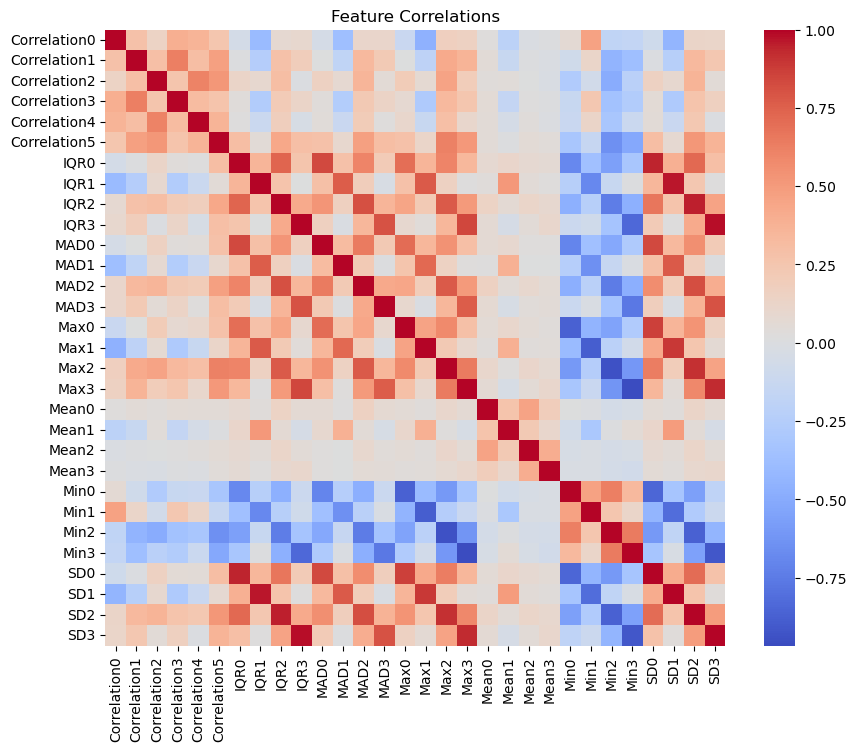

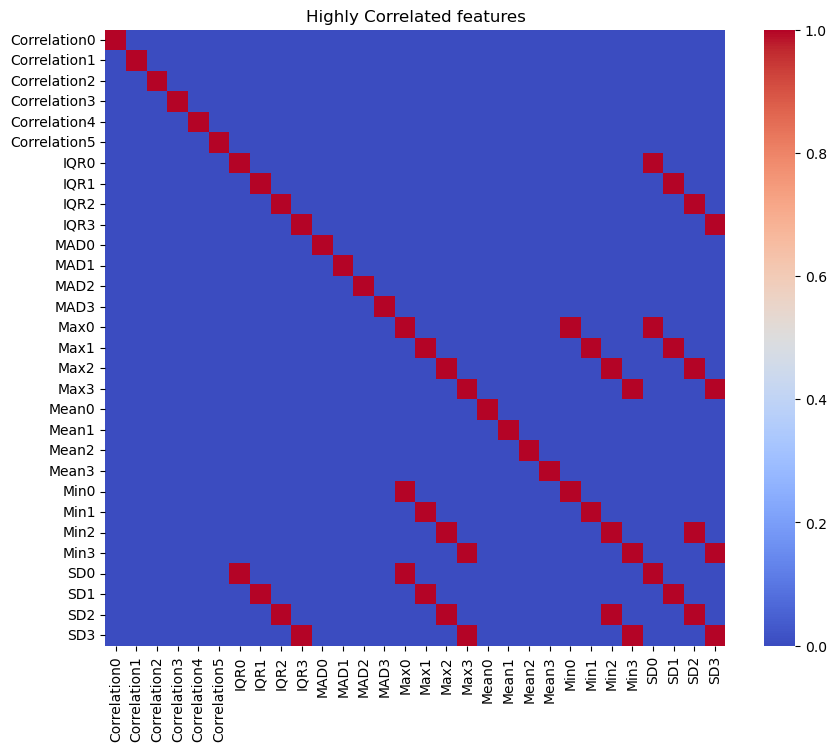

In [13]:
feature_corr_matrix = featured_df[stats_features].corr() 
plt.figure(figsize=(10,8))
sns.heatmap(feature_corr_matrix, cmap='coolwarm', annot=False)
plt.title(f"Feature Correlations")

high_corr_threshold = 0.85
plt.figure(figsize=(10,8))
sns.heatmap(np.abs(feature_corr_matrix) >= high_corr_threshold, cmap='coolwarm', annot=False)
plt.title(f"Highly Correlated features")


### Inspecting highly correlating `stats` feature pairs

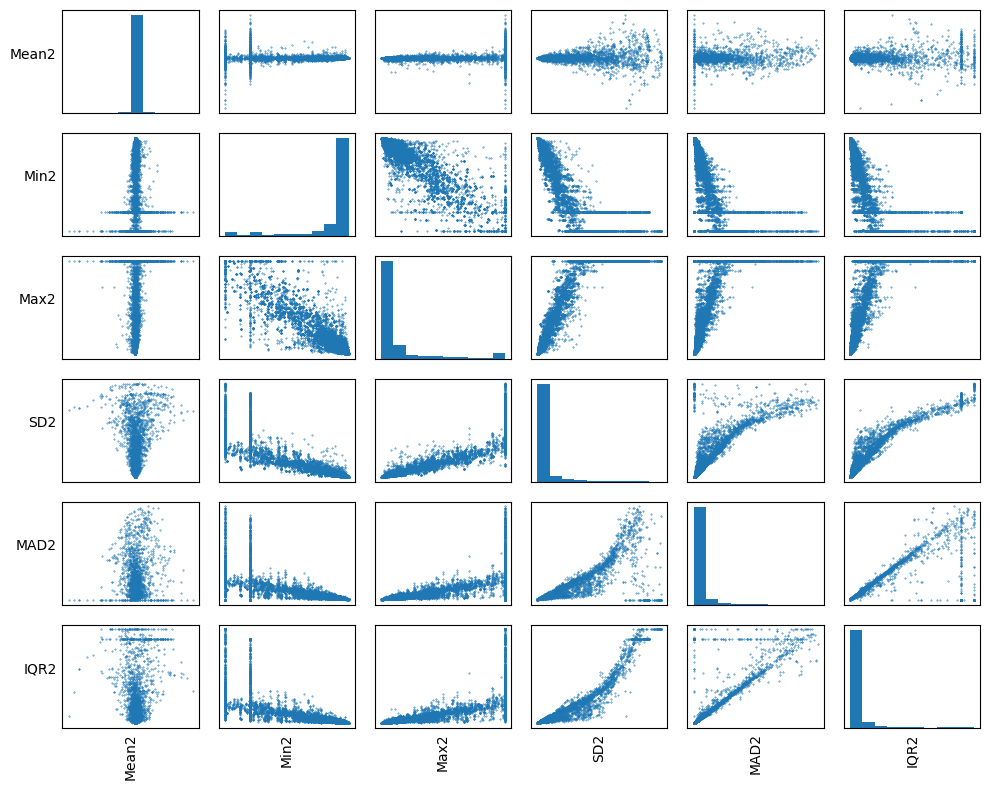

In [14]:
# entropy and complexity correlations
# for ch in [0,1,2,3]:
for ch in [2]:
    tmp_features = [ plate % ch for plate in ['Mean%d','Min%d','Max%d','SD%d', 'MAD%d', 'IQR%d']]
    scatter_plot_features(featured_df, tmp_features, with_jitter=False, jitter=1e-1)


## `info` features



Text(0.5, 1.0, 'Highly Correlated features')

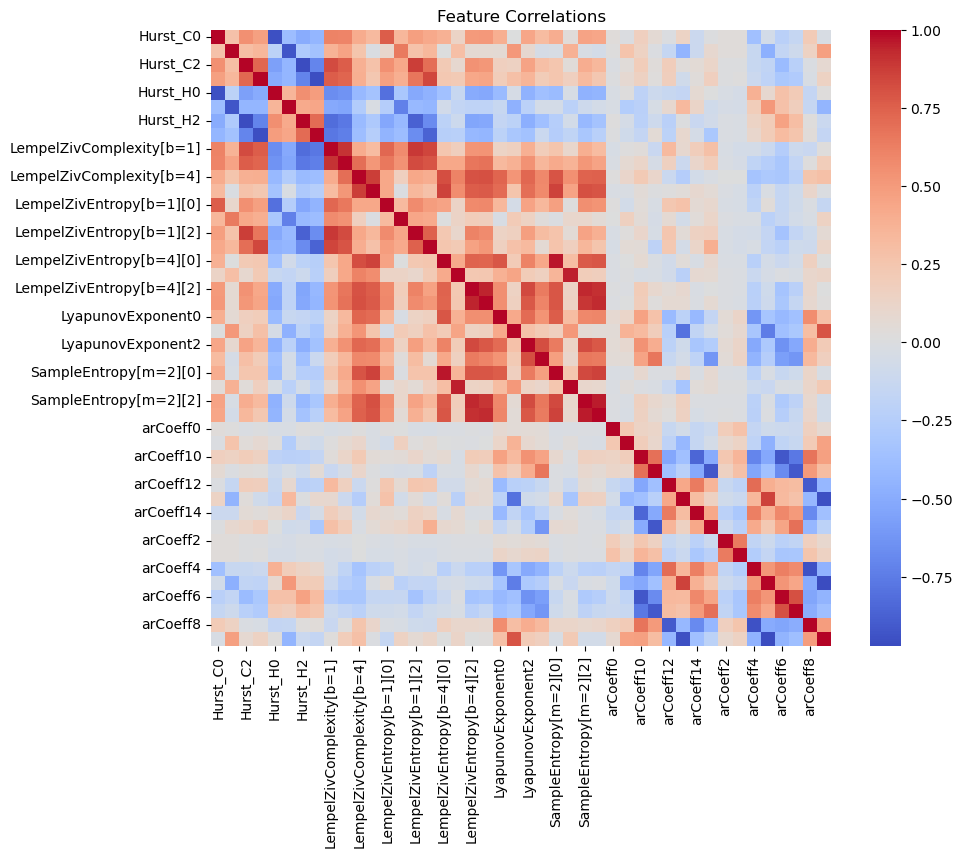

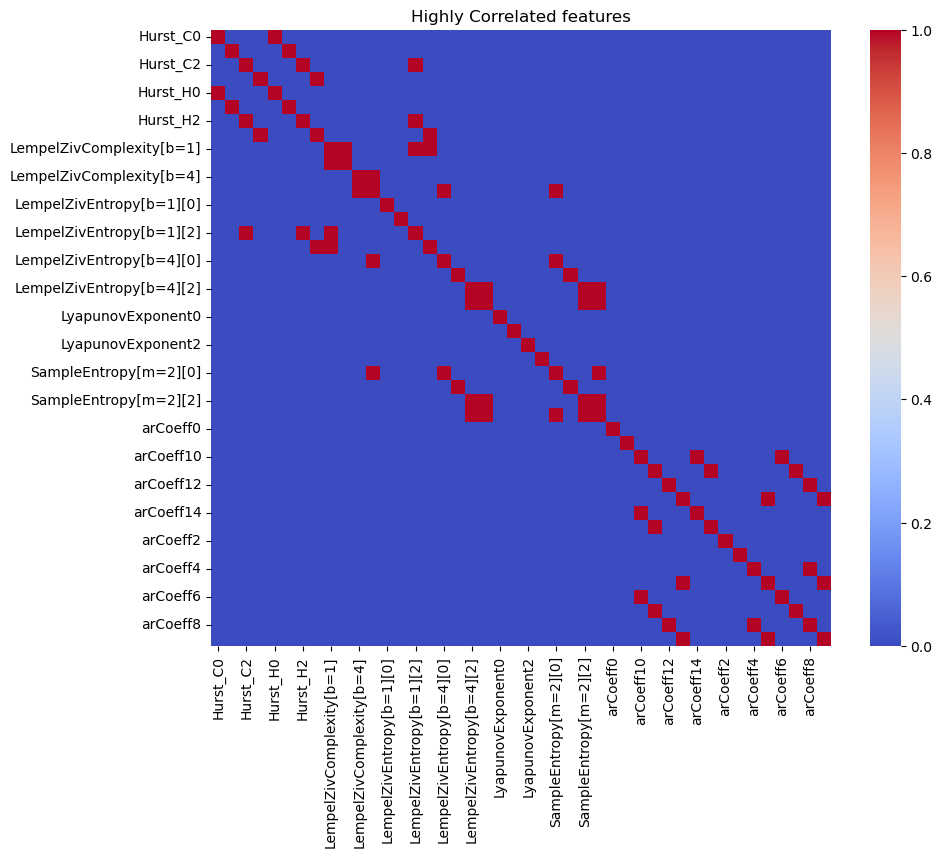

In [15]:

feature_corr_matrix = featured_df[info_features].corr()
plt.figure(figsize=(10,8))
sns.heatmap(feature_corr_matrix, cmap='coolwarm', annot=False)
plt.title(f"Feature Correlations")

high_corr_threshold = 0.85
plt.figure(figsize=(10,8))
sns.heatmap(np.abs(feature_corr_matrix) >= high_corr_threshold, cmap='coolwarm', annot=False)
plt.title(f"Highly Correlated features")


### Inspecting highly correlating `info` feature pairs

In [16]:
featured_df.columns

Index(['participant', 'condition', 'window index', 'Mean0', 'Mean1', 'Mean2',
       'Mean3', 'SD0', 'SD1', 'SD2',
       ...
       'LempelZivComplexity[b=8]', 'LempelZivEntropy[b=2][0]',
       'LempelZivEntropy[b=2][1]', 'LempelZivEntropy[b=2][2]',
       'LempelZivEntropy[b=2][3]', 'LempelZivEntropy[b=4][0]',
       'LempelZivEntropy[b=4][1]', 'LempelZivEntropy[b=4][2]',
       'LempelZivEntropy[b=4][3]', 'LempelZivComplexity[b=4]'],
      dtype='object', length=101)

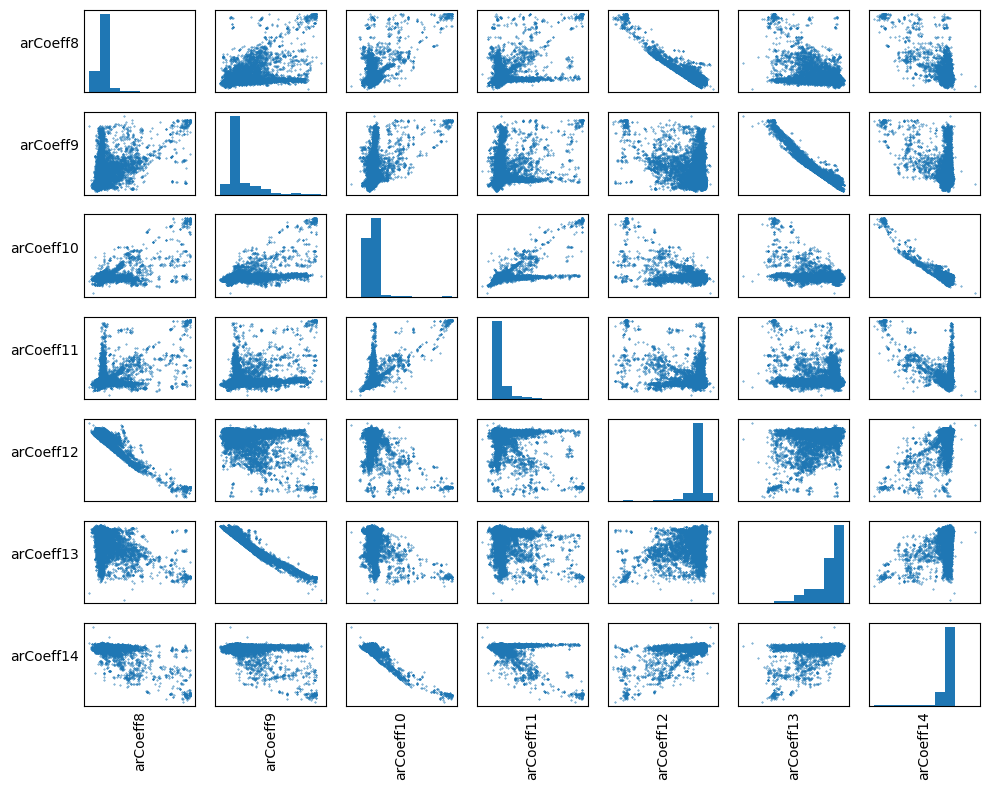

In [17]:
# entropy and complexity correlations
# for ch in [0,1,2,3]:
tmp_features = [ f'arCoeff{d}' for d in range(8,15) ]
scatter_plot_features(featured_df, tmp_features, with_jitter=False, jitter=1e-1)


tmp_features = ['SampleEntropy[m=2][0]', 'SampleEntropy[m=2][1]', 'SampleEntropy[m=2][2]', 'SampleEntropy[m=2][3]']


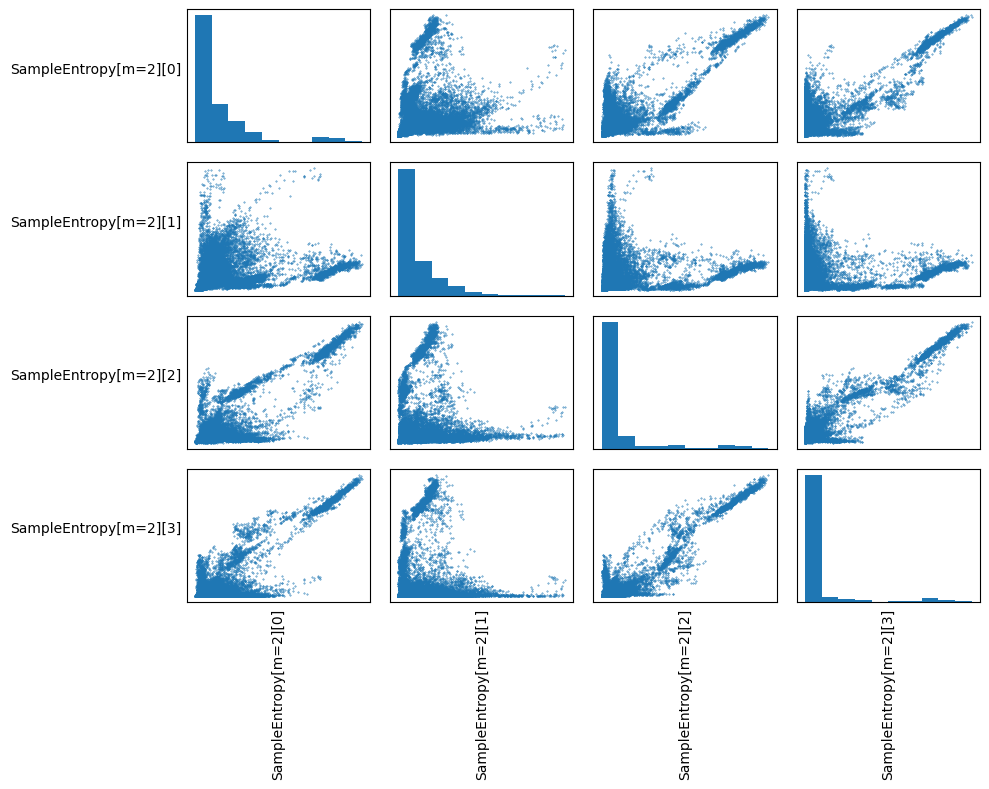

In [18]:
# entropy and complexity correlations
# for ch in [0,1,2,3]:
tmp_features = [ f for f in featured_df.columns if f.startswith('SampleEntropy') ][:5]
print(f"tmp_features = {tmp_features}")
scatter_plot_features(featured_df, tmp_features, with_jitter=False, jitter=1e-1)


tmp_features = ['Hurst_H0', 'Hurst_H1', 'Hurst_H2', 'Hurst_H3', 'Hurst_C0', 'Hurst_C1', 'Hurst_C2', 'Hurst_C3']


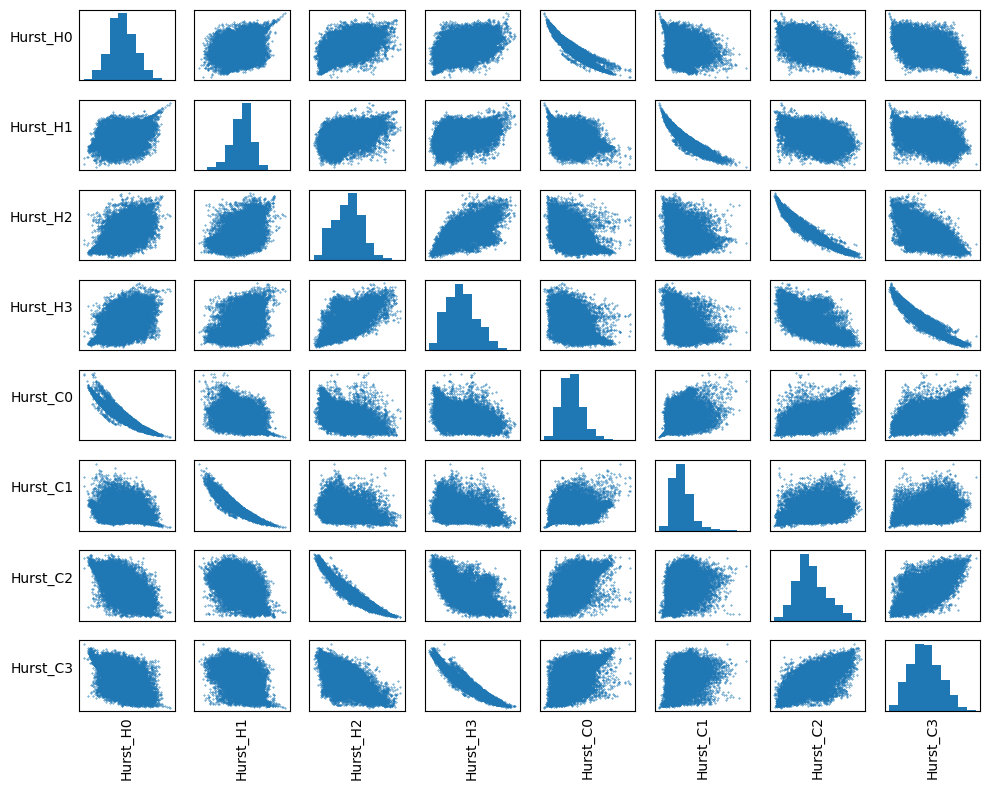

In [19]:
# entropy and complexity correlations
# for ch in [0,1,2,3]:
tmp_features = [ f for f in featured_df.columns if f.startswith('Hurst') ]
print(f"tmp_features = {tmp_features}")
scatter_plot_features(featured_df, tmp_features, with_jitter=False, jitter=1e-1)


In [20]:
featured_df.columns

Index(['participant', 'condition', 'window index', 'Mean0', 'Mean1', 'Mean2',
       'Mean3', 'SD0', 'SD1', 'SD2',
       ...
       'LempelZivComplexity[b=8]', 'LempelZivEntropy[b=2][0]',
       'LempelZivEntropy[b=2][1]', 'LempelZivEntropy[b=2][2]',
       'LempelZivEntropy[b=2][3]', 'LempelZivEntropy[b=4][0]',
       'LempelZivEntropy[b=4][1]', 'LempelZivEntropy[b=4][2]',
       'LempelZivEntropy[b=4][3]', 'LempelZivComplexity[b=4]'],
      dtype='object', length=101)

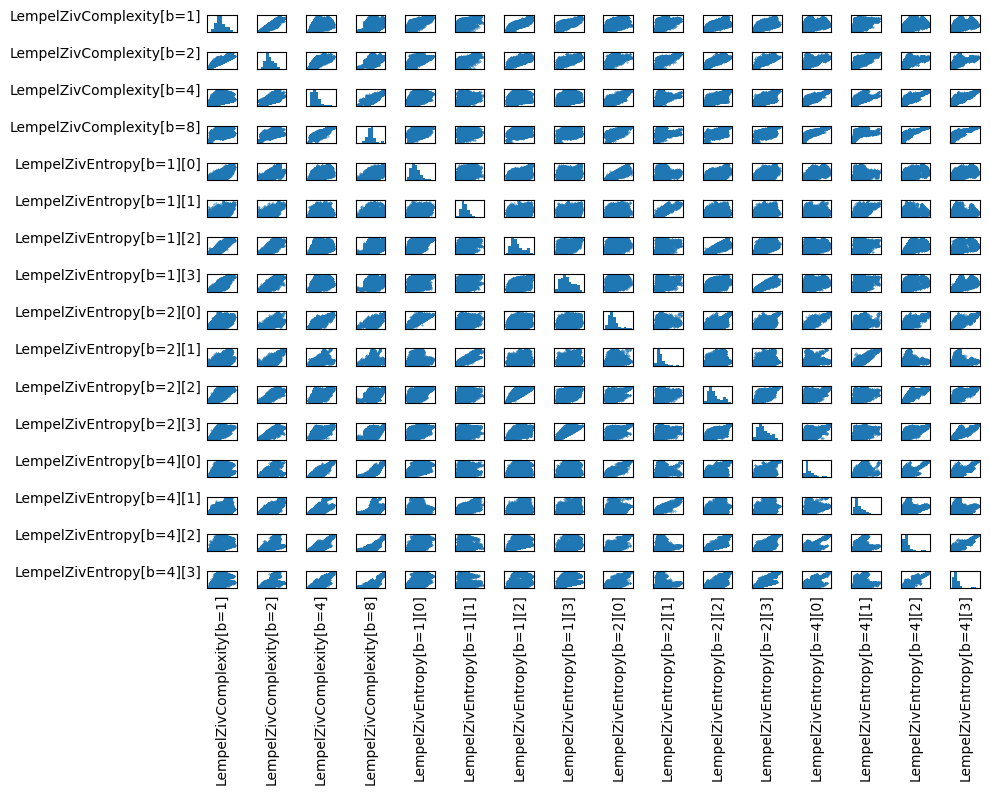

In [21]:
try:
    # entropy and complexity correlations
    # for ch in [0,1,2,3]:
    tmp_features = [ f for f in featured_df.columns if f.startswith('LempelZiv') ]
    tmp_features.sort()
    scatter_plot_features(featured_df, tmp_features, with_jitter=False, jitter=1e-1)
except:
    print("Skipping correlation analysis as not enough features")

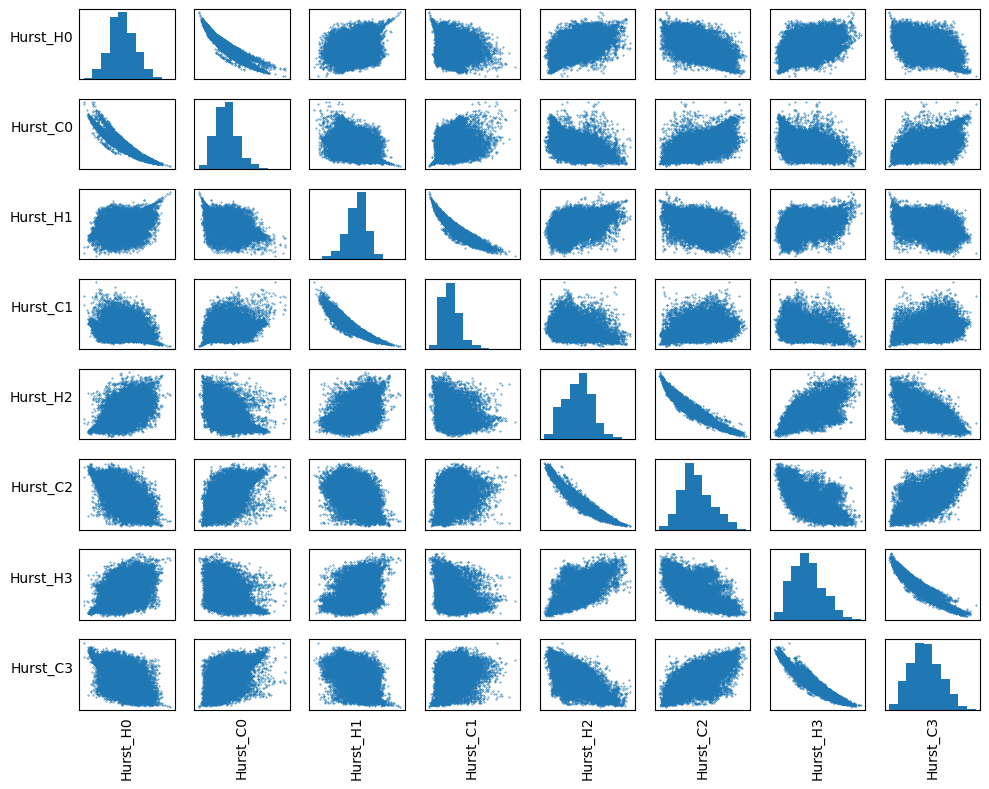

In [22]:
# entropy and complexity correlations
# for ch in [0,1,2,3]:
tmp_features = [ plate % ch for ch in range(4) for plate in ['Hurst_H%d','Hurst_C%d'] ]
scatter_plot_features(featured_df, tmp_features, with_jitter=False, jitter=1e-1)


## `freq` features


Text(0.5, 1.0, 'Highly Correlated features')

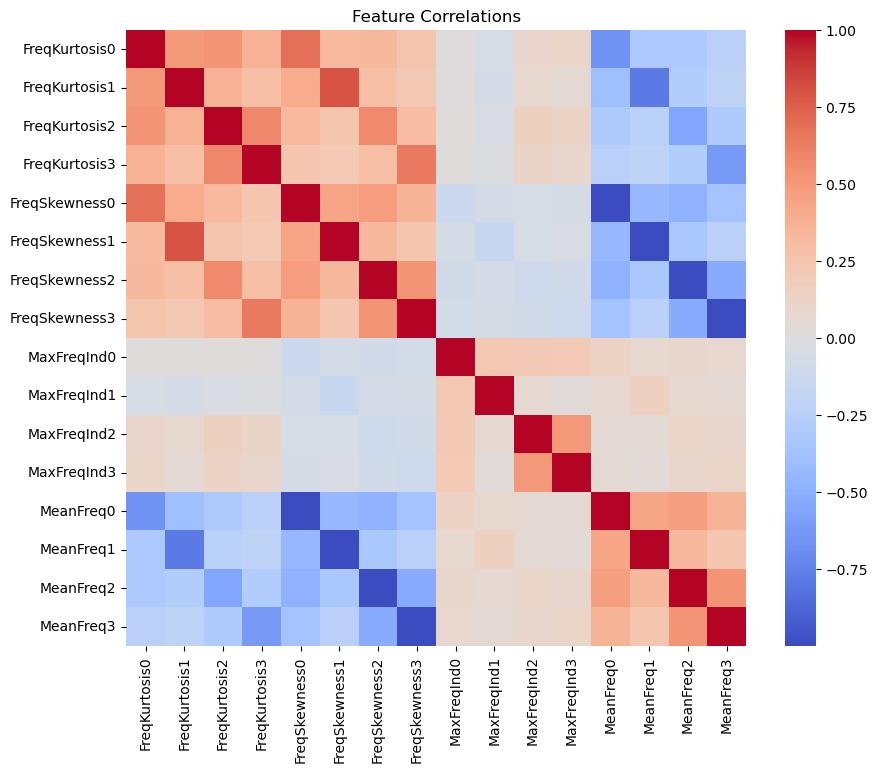

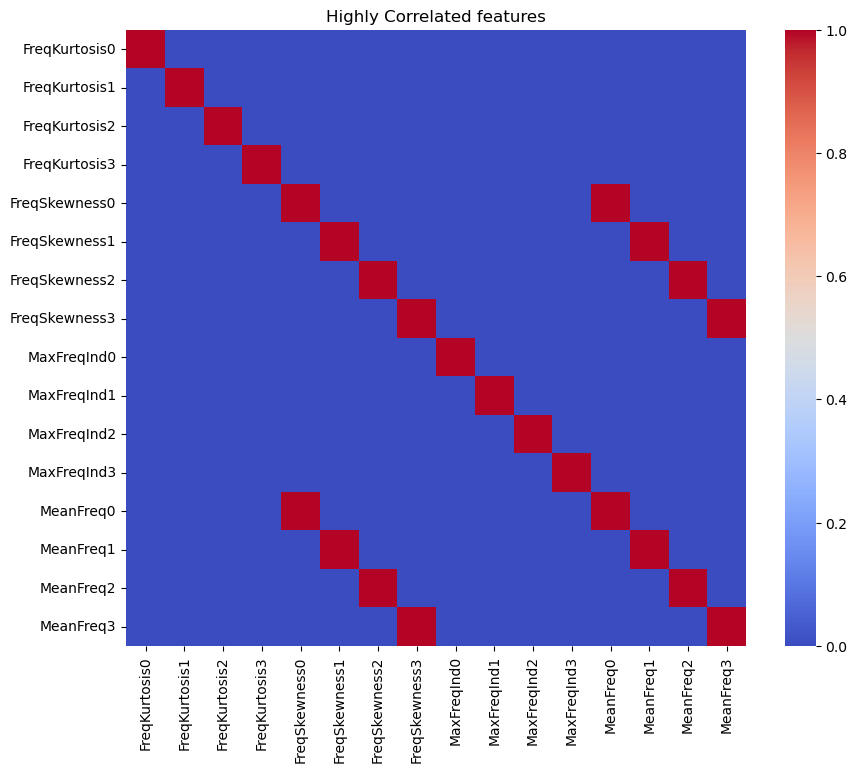

In [23]:

feature_corr_matrix = featured_df[freq_features].corr()
plt.figure(figsize=(10,8))
sns.heatmap(feature_corr_matrix, cmap='coolwarm', annot=False)
plt.title(f"Feature Correlations")

high_corr_threshold = 0.85
plt.figure(figsize=(10,8))
sns.heatmap(np.abs(feature_corr_matrix) >= high_corr_threshold, cmap='coolwarm', annot=False)
plt.title(f"Highly Correlated features")


### Inspecting highly correlating `stats` feature pairs

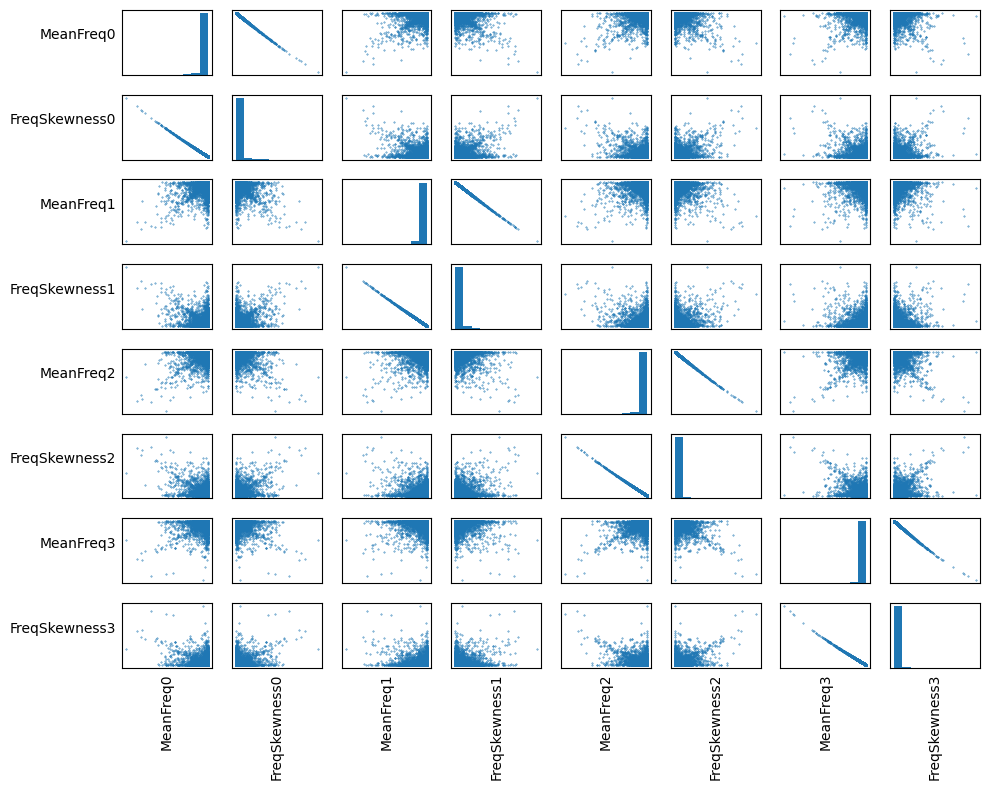

In [24]:
# entropy and complexity correlations
tmp_features = [ plate % ch for ch in [0,1,2,3] for plate in ['MeanFreq%d','FreqSkewness%d']]
scatter_plot_features(featured_df, tmp_features, with_jitter=False, jitter=1e-1)


# Density of highly correlated features 

### What proportion of our feature pairs overall are highly correlated 

Text(0.5, 1.0, 'Proportion of non-reflexive pairs more correlated than some threshold')

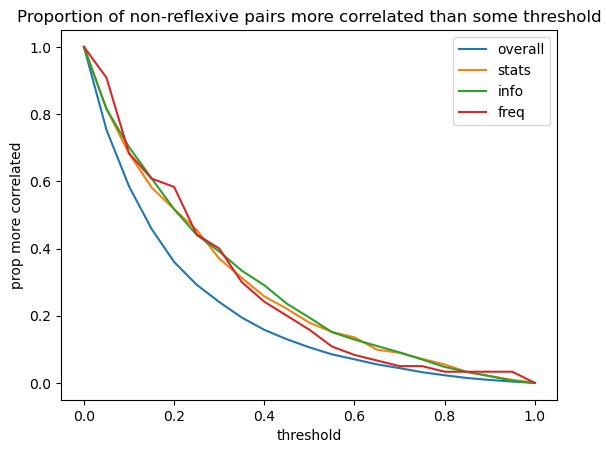

In [25]:

for tmp_features, group_name in [
        ( featured_df.columns, 'overall'), (stats_features,'stats'),
        (info_features, 'info'), (freq_features, 'freq')]:
    feature_corr_matrix = featured_df[tmp_features].corr()
    thresholds = np.linspace(0,1,21)
    num_more_correlated = np.empty(thresholds.size, dtype=int)
    for t,thresh in enumerate(thresholds):
    #     print(f"thresh = {thresh}")
        pairs = [(i,j) for i, j in zip(*np.where(np.abs(feature_corr_matrix) >= thresh)) if i != j]
        num_more_correlated[t] = len(pairs)
    prop_more_correlated = num_more_correlated /num_more_correlated[0]

    plt.plot(thresholds, prop_more_correlated, label=group_name)

plt.legend()
plt.xlabel('threshold')
plt.ylabel('prop more correlated')
plt.title("Proportion of non-reflexive pairs more correlated than some threshold")

## Feature correlations with conditions

In [26]:
conditions = np.unique(featured_df['condition'])
conditions
indep_conditions = []
for c in conditions:
    indep_condition = f'condition=={c}'
    featured_df[indep_condition] = featured_df['condition'] == c
    indep_conditions.append(indep_condition)

Text(0.5, 1.0, 'Label/Feature Correlations')

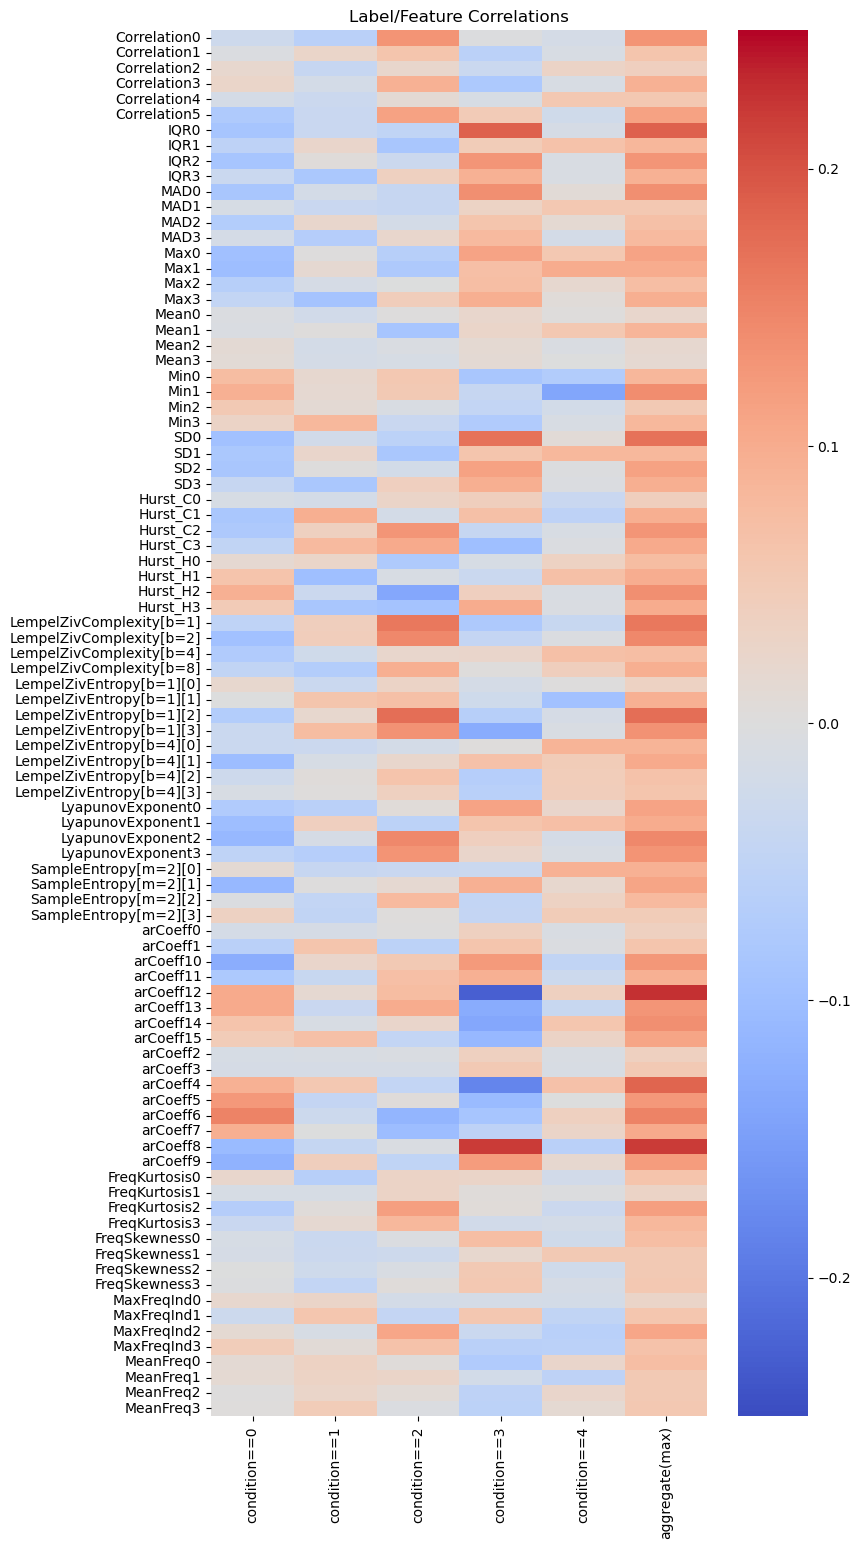

In [27]:

feature_cond_corr_df = featured_df[indep_conditions +stats_features+info_features+freq_features].corr()
feature_cond_corr_df = feature_cond_corr_df.loc[stats_features+info_features+freq_features,indep_conditions]

all_corrs = feature_cond_corr_df.to_numpy()
import math

feature_cond_corr_df['aggregate(max)'] = np.max(np.abs(all_corrs),axis=1)

## get a good set of limits for the colorbar
# remove rows with nans
rows_with_nan = np.unique(np.where(np.any(np.isnan(feature_cond_corr_df), axis=1))[0])
# .delete(x, [0, 1, 2], axis=0)
all_finite_corrs = np.delete(all_corrs, rows_with_nan, axis=0)
# print(f"rows_with_nan = {rows_with_nan}")
max_abs_val = np.max(np.abs(all_finite_corrs))
granularity = 40
max_abs_val = math.ceil(max_abs_val*granularity)/40
max_abs_val

fig_height = 0.2*len(info_features+stats_features+freq_features)
plt.figure(figsize=(8,fig_height))
ax = sns.heatmap(feature_cond_corr_df, cmap='coolwarm', annot=False)
ax.collections[0].set_clim(-max_abs_val,max_abs_val) 
plt.title(f"Label/Feature Correlations")


## Feature correlations with participant

In [28]:
participants = np.unique(featured_df['participant'])

indep_participants = []
for p in participants:
    indep_participant = f'participant=={p}'
    featured_df[indep_participant] = featured_df['participant'] == p
    indep_participants.append(indep_participant)

max_abs_val = 0.9


Text(0.5, 1.0, 'Participant/Feature Correlations')

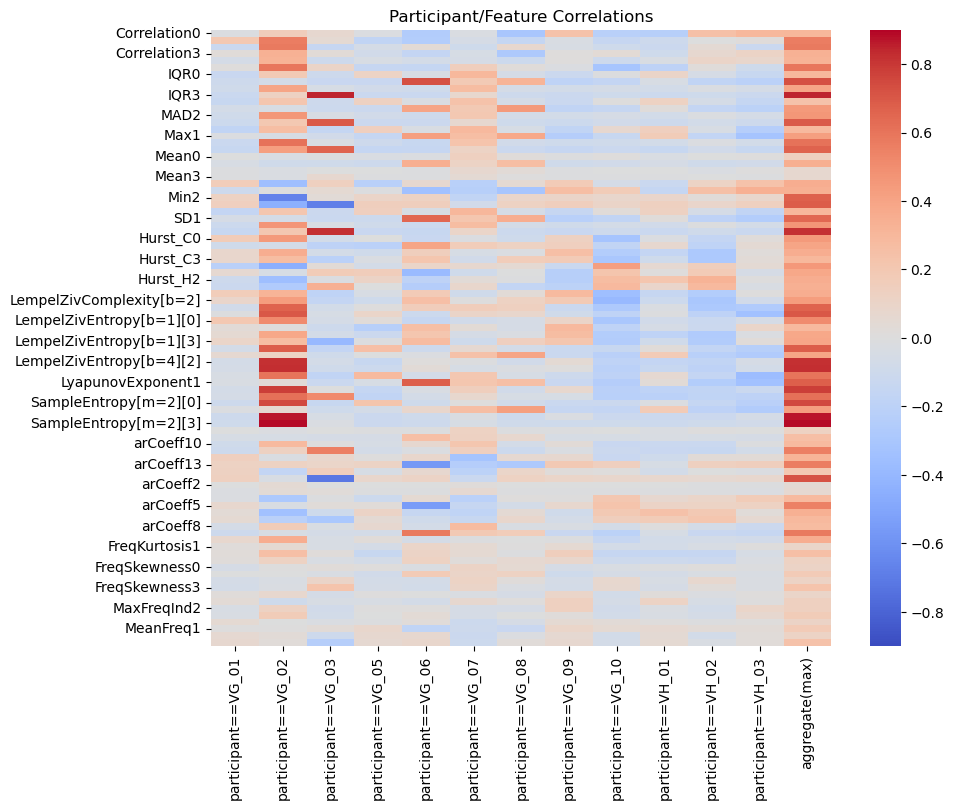

In [29]:

feature_cond_corr_df = featured_df[indep_participants +stats_features+info_features+freq_features].corr()
feature_cond_corr_df = feature_cond_corr_df.loc[stats_features+info_features+freq_features,indep_participants]

all_corrs = feature_cond_corr_df.to_numpy()
finite_corrs_mask = np.isfinite(all_corrs) & ~np.isnan(all_corrs)
max_abs_val = np.max(np.abs(all_corrs[finite_corrs_mask]))
max_abs_val = math.ceil(max_abs_val*granularity)/40
print(f"max_abs_val = {max_abs_val}")
granularity = 40
import math

feature_cond_corr_df['aggregate(max)'] = np.max(np.abs(all_corrs),axis=1)



plt.figure(figsize=(10,8))
ax = sns.heatmap(feature_cond_corr_df, cmap='coolwarm', annot=False)
ax.collections[0].set_clim(-max_abs_val,max_abs_val) 
plt.title(f"Participant/Feature Correlations")


## NaNs and Inifinite values

In [30]:
featured_df[stats_features].columns[np.any(np.isinf(featured_df[stats_features]), axis=0)]

Index([], dtype='object')

In [31]:
featured_df[info_features].columns[np.any(np.isinf(featured_df[info_features]), axis=0)]

Index([], dtype='object')

In [32]:
featured_df[freq_features].columns[np.any(np.isinf(featured_df[freq_features]), axis=0)]

Index([], dtype='object')

In [33]:
removed_columns

[]

In [34]:
featured_df[stats_features].columns[np.any(np.isnan(featured_df[stats_features]), axis=0)]

Index([], dtype='object')

In [35]:
featured_df[info_features].columns[np.any(np.isnan(featured_df[info_features]), axis=0)]

Index([], dtype='object')

In [36]:
featured_df[freq_features].columns[np.any(np.isnan(featured_df[freq_features]), axis=0)]

Index([], dtype='object')

In [37]:
rows_with_infinite = feature_cond_corr_df.index[np.any(np.isinf(feature_cond_corr_df), axis=1)]
rows_with_infinite

Index([], dtype='object')

In [38]:
rows_with_nan = feature_cond_corr_df.index[np.any(np.isnan(feature_cond_corr_df), axis=1)]
rows_with_nan

Index([], dtype='object')

In [39]:
for row_with_nan in rows_with_nan:
    plt.figure()
    plt.hist(featured_df[row_with_nan])
    plt.title(f"values for {row_with_nan}")

In [40]:

import pandas as pd
import numpy as np

# Example DataFrame
data = {
    'A': [1, 2, float('inf'), 4],
    'B': [float('-inf'), 5, 6, np.nan],
    'C': [8, 9, 10, 11]
}

df = pd.DataFrame(data)

# Filter rows with infinite or NaN values in float columns
filtered_df = df[~np.isinf(df.select_dtypes(include=[np.number])) & ~np.isnan(df.select_dtypes(include=[np.number]))].dropna()

print("DataFrame after removing rows with infinite or NaN values:")
print(filtered_df)

DataFrame after removing rows with infinite or NaN values:
     A    B  C
1  2.0  5.0  9


In [41]:
import pandas as pd
import numpy as np

# Example DataFrame
data = {
    'A': [1, 2, float('inf'), 4],
    'B': [float('-inf'), 5, 6, 7],
    'C': [8, 9, 10, 11],
    'D': ['apple', 'banana', 'orange', 'pear']
}

df = pd.DataFrame(data)

# Filter columns with infinite values and record removed columns
removed_columns = []
for col in df.select_dtypes(include=[np.number]).columns:
    if np.any(np.isinf(df[col])):
        removed_columns.append(col)
        del df[col]

print("DataFrame after removing columns with infinite values:")
print(df)
print("Removed columns:", removed_columns)

DataFrame after removing columns with infinite values:
    C       D
0   8   apple
1   9  banana
2  10  orange
3  11    pear
Removed columns: ['A', 'B']
